In [33]:

import pandas as pd 
import numpy as np
import gc
import time
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

In [34]:
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

In [35]:

from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   

In [5]:
from sklearn.metrics import confusion_matrix
from itertools import combinations

In [8]:
start_time=time.time()
color = sns.color_palette()
warnings.filterwarnings("ignore")

In [24]:
# nltk.download('stopwords')
eng_stopwords = set(stopwords.words("english"))
# stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\qianm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [11]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [12]:
print(train.shape)
print(test.shape)
train.head(10)

(159571, 8)
(153164, 2)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [13]:
tag_cols = train.columns[2:]

In [14]:
tag_cols

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [15]:
rowsums = train[tag_cols].sum(axis = 1)
train['clean'] = (rowsums == 0)

print("Total comments = ", len(train))
print("Total clean comments = ", sum(train['clean']))
print("Total tags = ", train[tag_cols].sum().sum())
# some comments have more than one tags

Total comments =  159571
Total clean comments =  143346
Total tags =  35098


### Missing value

In [16]:
print("Check for missing values in Train dataset")
null_check=test.isnull().sum()
print(null_check)
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id              0
comment_text    0
dtype: int64


### Frequency overview

toxic             15294.0
severe_toxic       1595.0
obscene            8449.0
threat              478.0
insult             7877.0
identity_hate      1405.0
clean            143346.0
dtype: float64


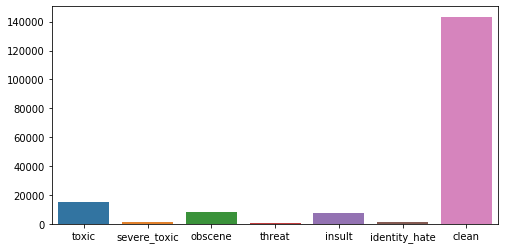

In [17]:
x = train.iloc[:,2:].sum()
print(x)
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values)

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64


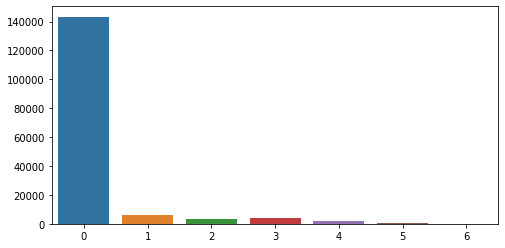

In [18]:
# tags total count

total_tags = train.iloc[:,2:-1].sum(axis = 1)
print(total_tags.value_counts())
plt.figure(figsize=(8,4))
sns.barplot(total_tags.value_counts().index, total_tags.value_counts().values)

### Correlation btw labels
- Confusion matrix and Cramers' stats

In [19]:
# correlation btw categorical var

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [20]:
train['total_tags'] = total_tags
multi = train[train['total_tags'] > 1][tag_cols]

# pair-wise confusion matrix
for a,b in combinations(tag_cols, 2):
    x1=confusion_matrix(multi[a].astype('category'), 
                        multi[b].astype('category'))
    print(pd.DataFrame(x1, index = [a+'0', a+'1'], columns=[b+'0', b+'1']))
    print(f'Cor btw {a} and {b} is:',cramers_corrected_stat(x1)) # don't seem to work really
    print('\n')

        severe_toxic0  severe_toxic1
toxic0            237              0
toxic1           8033           1595
Cor btw toxic and severe_toxic is: 0.067257116026614


        obscene0  obscene1
toxic0        31       206
toxic1      1702      7926
Cor btw toxic and obscene is: 0.014472336042847112


        threat0  threat1
toxic0      230        7
toxic1     9179      449
Cor btw toxic and threat is: 0.004157834083072765


        insult0  insult1
toxic0        5      232
toxic1     2284     7344
Cor btw toxic and insult is: 0.07696279040040264


        identity_hate0  identity_hate1
toxic0             188              49
toxic1            8326            1302
Cor btw toxic and identity_hate is: 0.029206828797700493


               obscene0  obscene1
severe_toxic0      1655      6615
severe_toxic1        78      1517
Cor btw severe_toxic and obscene is: 0.14559602726430212


               threat0  threat1
severe_toxic0     7926      344
severe_toxic1     1483      112
Cor btw severe

### WordClouds

In [21]:
#clean comments
clean_mask=np.array(Image.open("safe-zone.png"))
clean_mask=clean_mask[:,:,1]

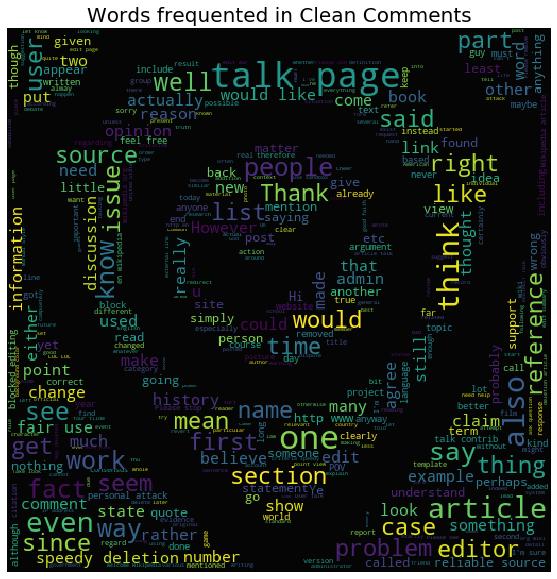

In [25]:
#wordcloud for clean comments

subset=train[train['clean'] == True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=2019), alpha=0.98)


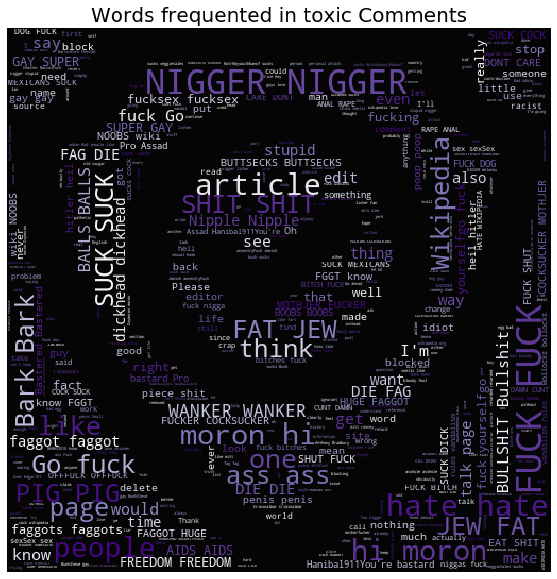

In [26]:
subset=train[train['toxic'] == True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Purples' , random_state=2019), alpha=0.98)

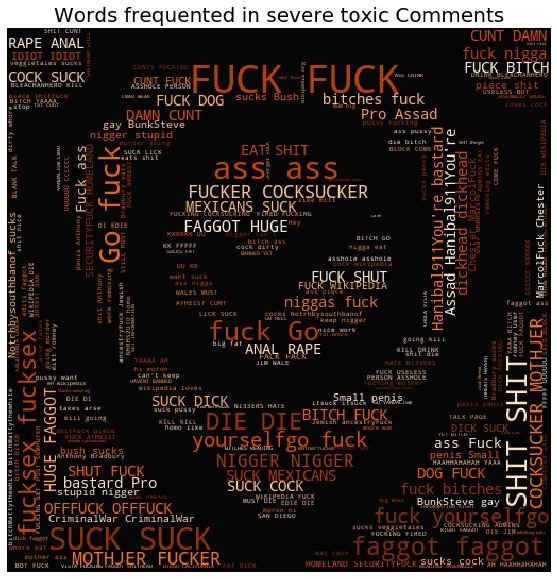

In [27]:
subset=train[train['severe_toxic'] == True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in severe toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Oranges' , random_state=2019), alpha=0.98)

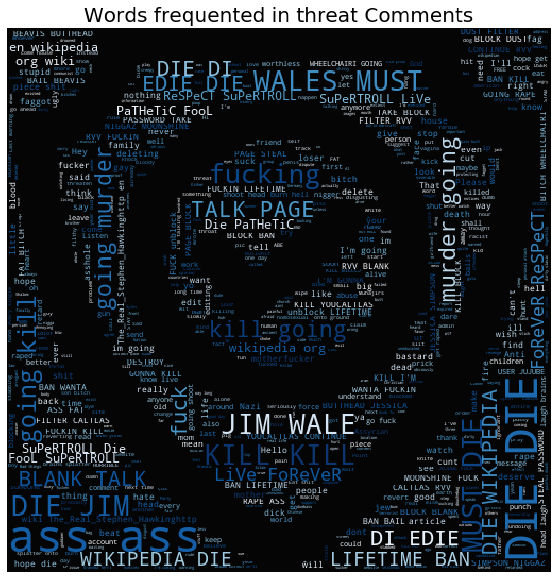

In [29]:
subset=train[train['threat'] == True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in threat Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Blues' , random_state=2019), alpha=0.98)

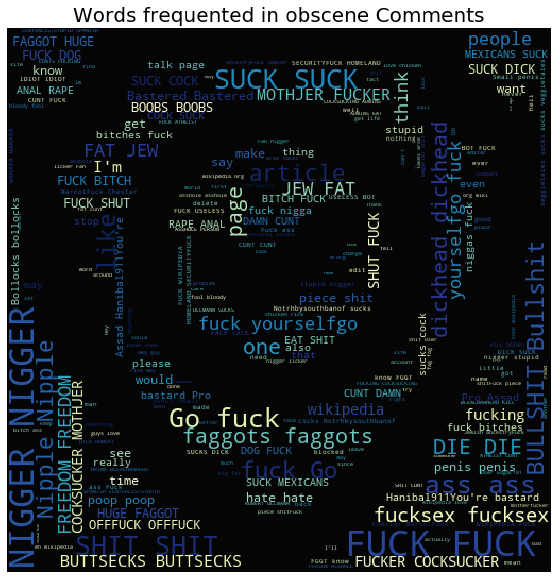

In [31]:
subset=train[train['obscene'] == True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in obscene Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'YlGnBu' , random_state=2019), alpha=0.98)

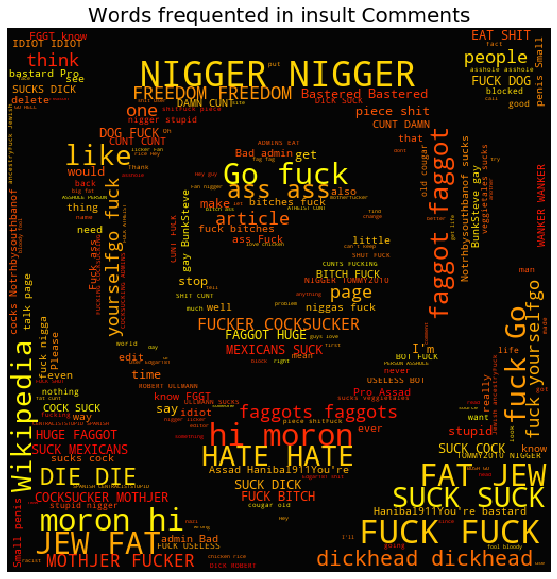

In [32]:
subset=train[train['insult'] == True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'autumn' , random_state=2019), alpha=0.98)